# Exam Project | Face Recognizer
By **Pernille Lørup & Stephan Djurhuus**  
Institute **CPHBusiness**  

Education **Software Development**  
Elective **Artificial Intelligence**  

## Package Imports

In [1]:
import cv2
import numpy as np

import tensorflow as tf
from tensorflow.keras import models, backend
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Dropout

## Module Imports

In [2]:
import sys
sys.path.append('../')
from FaceDetector import FaceDetector
from FaceRecognizer import FaceRecognizer
from DataGenerator import DataGenerator
from Utilities import Displayer

## Global Constants

In [3]:
face_detector = FaceDetector('FACE_DEFAULT_NB')

classes = ['dad', 'mom', 'son', 'daughter']

dad_path = '../data/PersonGroup/Family1-Dad'
mom_path = '../data/PersonGroup/Family1-Mom'
son_path = '../data/PersonGroup/Family1-Son'
daughter_path = '../data/PersonGroup/Family1-Daughter'

## Data Generation

In [4]:
(train_dad_data, test_dad_data) = DataGenerator.generate(dad_path, 150, label=0, test_size=.2, face_detector=face_detector)
(train_mom_data, test_mom_data) = DataGenerator.generate(mom_path, 150, label=1, test_size=.2, face_detector=face_detector)
(train_son_data, test_son_data) = DataGenerator.generate(son_path, 150, label=2, test_size=.2, face_detector=face_detector)
(train_daughter_data, test_daughter_data) = DataGenerator.generate(daughter_path, 150, label=3, test_size=.2, face_detector=face_detector)

(train_images, train_labels) = DataGenerator.merge_shuffle([train_dad_data, train_mom_data, train_son_data, train_daughter_data])
(test_images, test_labels) = DataGenerator.merge_shuffle([test_dad_data, test_mom_data, test_son_data, test_daughter_data])

# greyscalling
train_images_gray = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in train_images])
test_images_gray = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in test_images])

## Data Validations

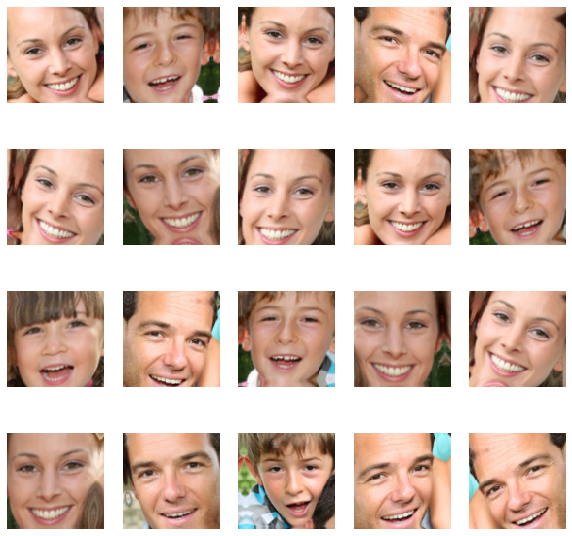

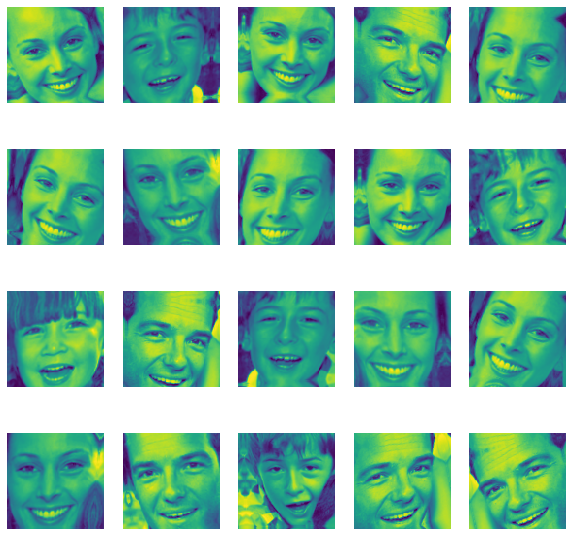

In [5]:
Displayer.images(train_images[200:], 20)
Displayer.images(train_images_gray[200:], 20)

## Model Configurations

### Convolutional Neural Network

In [6]:
cnn_model = models.Sequential([
    Conv2D(25, (5, 5), activation='relu', input_shape=(100, 100, 3)),
    Dropout(.2),
    MaxPooling2D((5, 5)),
    Conv2D(50, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(50, (3, 3), activation='relu'),
    Flatten(),
    Dense(len(classes))
])

### Artificial Neural Network

**Softmax** ≈ 50% accuracy  
**Sigmoid** ≈ 50% accuracy  
**TanH** ≈ 50% accuracy

In [7]:
def positive_softmax(input_data):
    relu_data = backend.relu(input_data)        # excluding negative values
    softmax_data = backend.softmax(relu_data)   # 
    return softmax_data

ann_model = models.Sequential([
    Flatten(input_shape=(100, 100)),
    Dense(500, activation='relu'),
    Dense(250, activation='sigmoid'),
    Dense(len(classes)),
])

## Face Recognizer Instantiations

In [8]:
cnn_recognizer = FaceRecognizer(classes, face_detector, model=cnn_model)
ann_recognizer = FaceRecognizer(classes, face_detector, model=ann_model)

## Model Training

In [9]:
# cnn_recognizer.train_model((train_images, train_labels), (test_images, test_labels), epochs=5)
# ann_recognizer.train_model((train_images_gray, train_labels), (test_images_gray, test_labels), epochs=15)

## Save & Load Model with History

In [10]:
# cnn_recognizer.save_model('../models/cnn_model_2of4')
cnn_recognizer.load_model('../models/cnn_model_3of4')
cnn_recognizer.model_summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 25)        700       
_________________________________________________________________
dropout (Dropout)            (None, 98, 98, 25)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 25)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 50)        11300     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 50)        22550     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 50)        0

In [11]:
# ann_recognizer.save_model('../models/ann_model_2of4')
ann_recognizer.load_model('../models/ann_model_3of4')
ann_recognizer.model_summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               5000500   
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 1004      
Total params: 5,126,754
Trainable params: 5,126,754
Non-trainable params: 0
_________________________________________________________________


## Model Train History

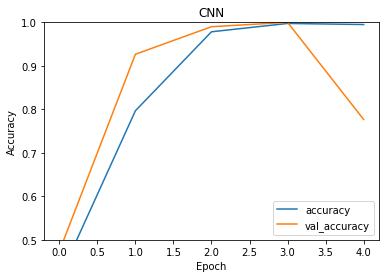

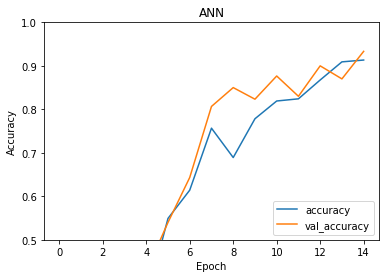

In [12]:
Displayer.acc_history(cnn_recognizer.history, 'CNN', save_as='cnn_history_3of4.png')
Displayer.acc_history(ann_recognizer.history, 'ANN', save_as='ann_history_3of4.png')

## Model Confusion Matrix

### Convolutional Neural Network

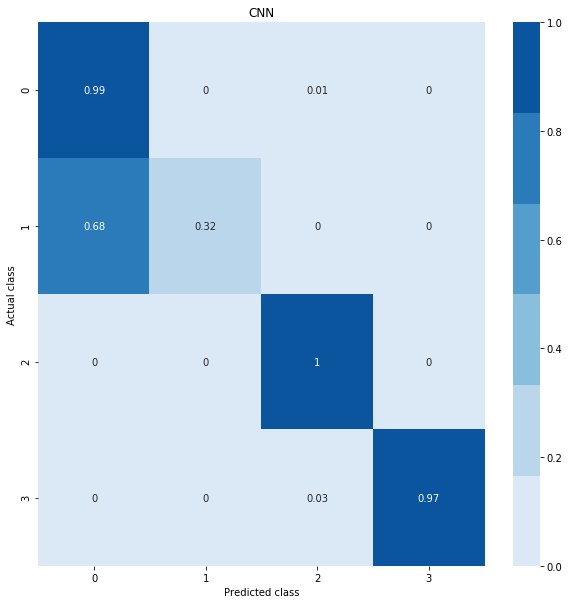

In [13]:
predictions = cnn_recognizer.recognize_many(test_images)
Displayer.conf_matrix(predictions, test_labels, 'CNN', save_as='cnn_conf_matrix_3of4.png')

### Artificial Neural Network

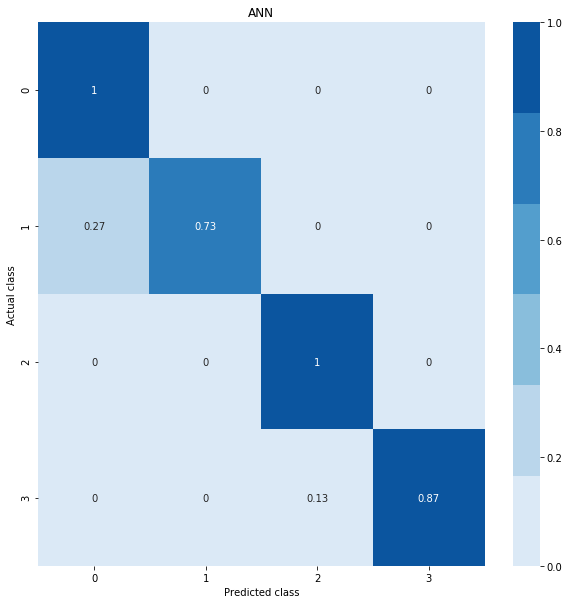

In [14]:
predictions = ann_recognizer.recognize_many(test_images_gray)
Displayer.conf_matrix(predictions, test_labels, 'ANN', save_as='ann_conf_matrix_3of4.png')

## Model Validations

In [15]:
test_image_path = '../data/identification1.jpg'
test_image = cv2.imread(test_image_path)
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

faceDetector = FaceDetector('FACE_ALT2_NB')
faces_data = faceDetector.face_details(test_image)

### Convolutional Neural Network

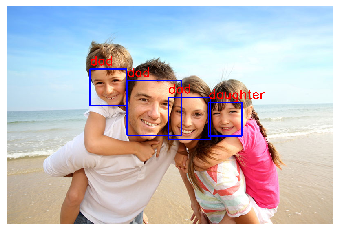

In [16]:
cnn_prediction_data = cnn_recognizer.face_predictions(faces_data)
Displayer.mark_predictions(test_image.copy(), cnn_prediction_data, classes, save_as='cnn_image_3of4.png')

### Artificial Neural Network

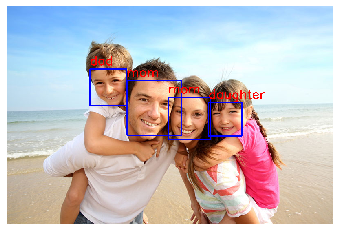

In [17]:
ann_prediction_data = ann_recognizer.face_predictions(faces_data, gray=True)
Displayer.mark_predictions(test_image.copy(), ann_prediction_data, classes, save_as='ann_image_3of4.png')